# 📊 Exploratory Data Analysis (EDA)


## 1. Import Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## 2. Load Cleaned Dataset

In [2]:
df = pd.read_csv(r'D:\Topic_13_Project\Topic_13_Retail_Store_Sales_Time_Series\data\processed\train_cleaned.csv')
df['date'] = pd.to_datetime(df['date'])
df.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


## 3. Data Aggregation

### Sales by time periods ( Daily, Weekly, Monthly, Yearly )

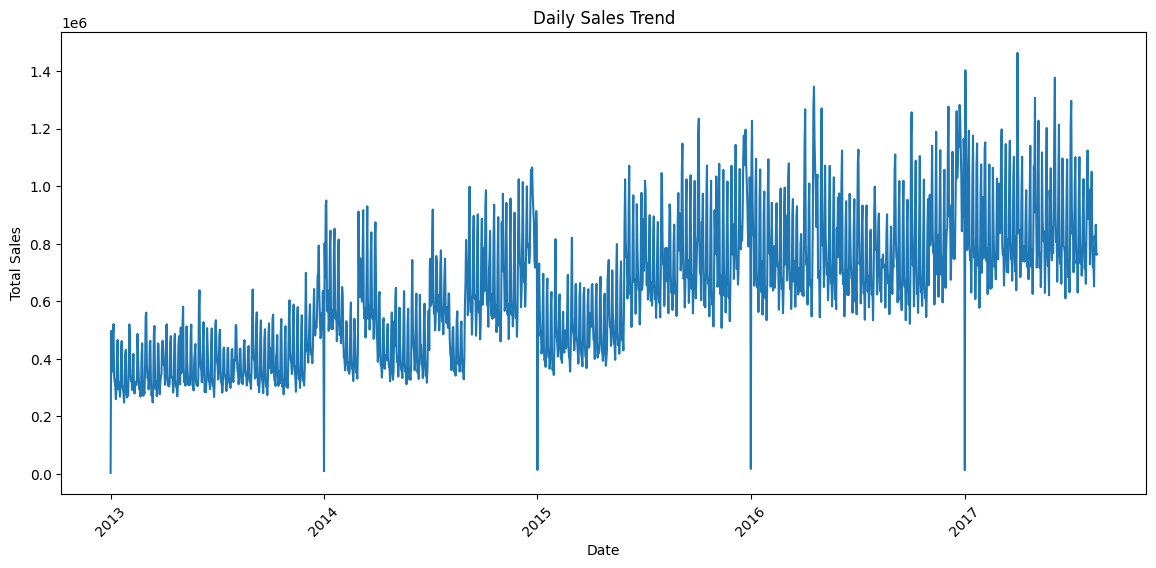

In [3]:
# Daily Sales Trend
daily_sales = df.groupby('date')['sales'].sum().reset_index()
plt.figure(figsize=(14, 6))
sns.lineplot(data=daily_sales, x='date', y='sales')
plt.title('Daily Sales Trend')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.xticks(rotation=45)
plt.show()

C:\Users\GIGABYTE\AppData\Local\Temp\ipykernel_24792\102315082.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_sales = df.groupby(pd.Grouper(key='date', freq='M'))['sales'].sum().reset_index()


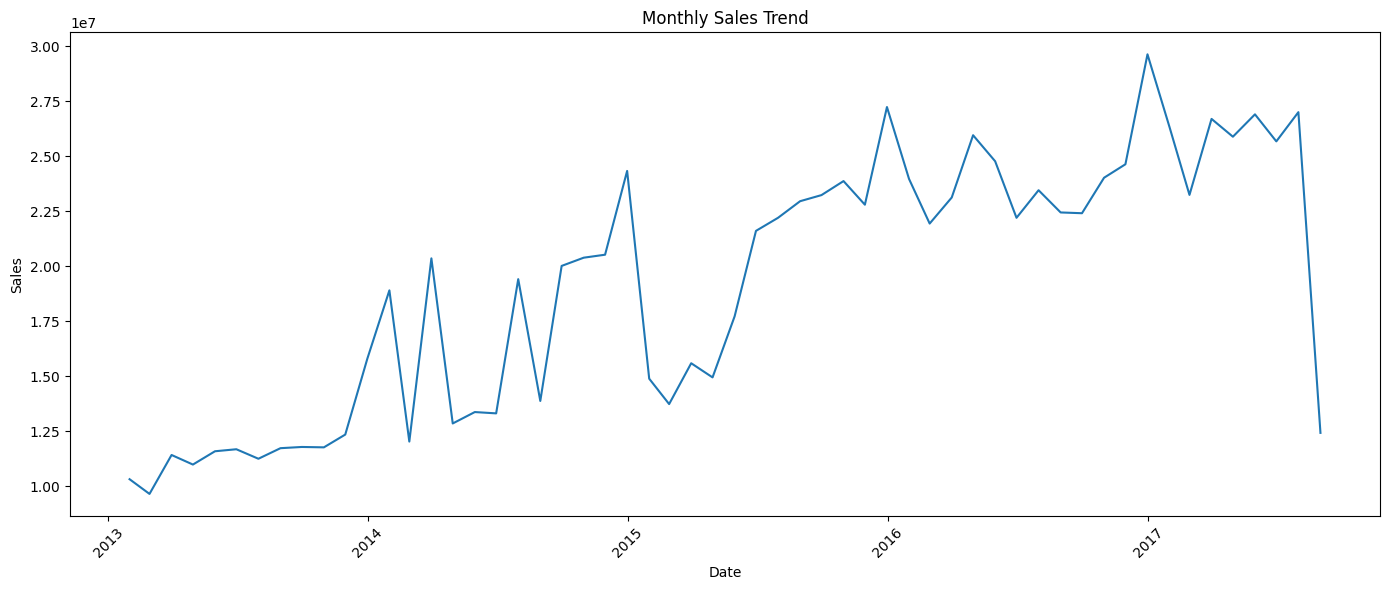

In [4]:
# Monthly Sales Trend
monthly_sales = df.groupby(pd.Grouper(key='date', freq='M'))['sales'].sum().reset_index()
plt.figure(figsize=(14, 6))
sns.lineplot(data=monthly_sales, x='date', y='sales')
plt.title('Monthly Sales Trend')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

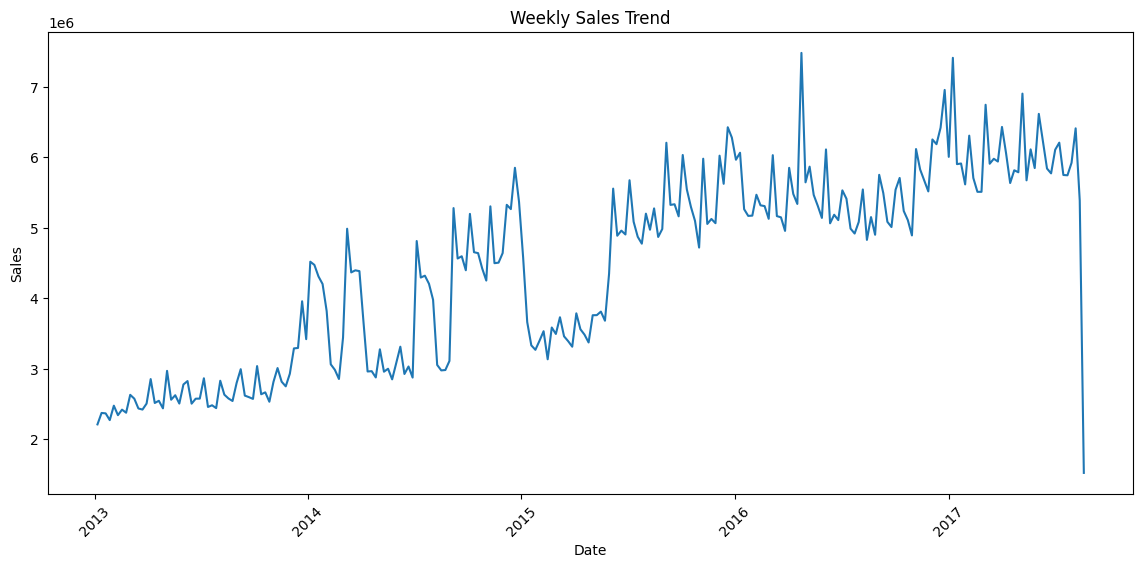

In [5]:
# Weekly Sales Trend
weekly_sales = df.groupby(pd.Grouper(key='date', freq='W'))['sales'].sum().reset_index()
plt.figure(figsize=(14, 6))
sns.lineplot(data=weekly_sales, x="date", y='sales')
plt.title('Weekly Sales Trend')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.xticks(rotation=45) 
plt.show()